In [52]:
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np 
import pandas as pd
from string import ascii_letters
import os
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /Users/brand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/brand/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/brand/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# PREPROCESSING THE INGREDIENTS

In [53]:
# need to remove these from ingredients
measurements = (['tablespoon', 'tbsp', 'teaspoon', 'tsp', 'cup', 'pint', 'pt', 
                 'quart', 'qt', 'gallon', 'gal', 'ounce', 'ounc', 'ounces', 'oz', 'fluid', 'fl', 'pound', 
                 'lb', 'liter', 'litre', 'l', 'ml', 'gram', 'g', 'inch', 'diameter', 'meter', 'medium',
                 'grill', 'cm', 'handful', 'size', 'firm', 'cupg', 'cupsg', 'cupsml', 'x', 'little', 'divided',
                 'total', 'more', 'package', 'bag', 'bottle', 'tbspg', 'xxinch', 'box', 'instructions', 'info',
                 'ozg', 'lbg', 'kg'])

DATASET_LIMIT = 5000

In [54]:
is_noun = lambda pos: pos[:2] == 'NN'
stemmer = nltk.stem.PorterStemmer()

all_ingredients = []

def parse_ingredients(row):
    list = eval(row['Cleaned_Ingredients'])
    ingredients = []
    for ingredient in list:
        # removing non-letters
        letter_only = ''.join(l for l in ingredient if l in set(ascii_letters + ' '))
        # tokenizing into words
        tokenized = nltk.word_tokenize(letter_only)
        # remove all except nouns, and remove measurements
        nouns = [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN' or pos[:2] == 'NNS')]
        nouns = [noun for noun in nouns if (noun not in measurements) and (stemmer.stem(noun) not in measurements)]
        if len(tokenized) > 0 and len(nouns) == 0:
            nouns.append(tokenized[-1])
        # add as new row, also add to a full ingredient list as features
        joined = ' '.join(nouns)
        ingredients.append(joined)
        if joined not in all_ingredients:
            all_ingredients.append(joined)
    return ','.join(ingredients)

In [55]:
df = pd.read_csv('data/food.csv')
df = df[df.Image_Name != '#NAME?']
df = df.iloc[:DATASET_LIMIT]

# add column for ingredients that are cleaned and parsed
df['parsed_ingredients'] = df.apply(parse_ingredients, axis=1)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

In [57]:
ingredient_strings = df['parsed_ingredients']
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','))
vectorized_documents = vectorizer.fit_transform(ingredient_strings)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Reducing Dimensions using PCA

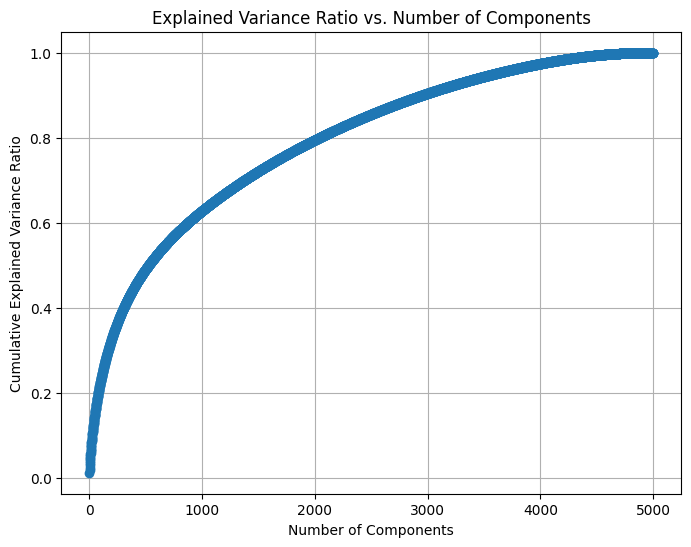

In [98]:
#
# DON'T RUN
# FINDING THE NUMBER OF COMPONENTS
#

pca = PCA()
pca.fit_transform(vectorized_documents.toarray())

# get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [58]:
# this is for the dataset of 5000
# if using full dataset, can go between 1500-1750
NUM_COMPONENTS = 900
pca = PCA(n_components=NUM_COMPONENTS)
reduced_ingredients = pca.fit_transform(vectorized_documents.toarray())

In [59]:
all_ingredients = vectorizer.get_feature_names_out()
ingredient_component_mapping = pd.DataFrame(pca.components_, columns=all_ingredients)
print(ingredient_component_mapping)

               abita amber beer     about     above  absinthe  absinthe rinse  \
0    0.000189         -0.000202  0.000778  0.000513 -0.000460       -0.000176   
1   -0.001389         -0.000178 -0.000873 -0.000397 -0.003139       -0.001152   
2   -0.000582          0.000435  0.000502 -0.000512 -0.002570       -0.000786   
3    0.001782          0.000231  0.000635  0.000727  0.001343        0.000472   
4    0.001614          0.001403  0.000142  0.000156 -0.000074        0.000070   
..        ...               ...       ...       ...       ...             ...   
895 -0.001906         -0.003507  0.003720  0.000307  0.038112        0.004226   
896  0.027042          0.012885 -0.001168 -0.002425  0.011569       -0.006361   
897 -0.011942         -0.000975 -0.004266 -0.004149 -0.015247        0.005116   
898 -0.001746          0.006369  0.004887 -0.004762 -0.010440       -0.002630   
899  0.022218          0.008127  0.002772 -0.000100  0.002808       -0.010063   

     accompaniment baguette

In [60]:
pca_ingredients = []
for i, pc in enumerate(pca.components_):
    index = np.argsort(np.abs(pc))[::-1]
    
    found = False
    i = 0
    while found == False:
        ing = all_ingredients[index[i]]
        if ing in pca_ingredients:
            i += 1
        else:
            pca_ingredients.append(ing)
            found = True

In [61]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [62]:
model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model = CLIPModel.from_pretrained(model_name)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [63]:
IMAGE_SIZE = (224,224)
clip_model.eval()

def encode_image(image):
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    return image_features

def prepare_image (image):
    img = Image.open (image)
    img = img.resize (IMAGE_SIZE)
    #img = np.expand_dims(img,axis = 0 )
    #img = np.array(img)/255.0
    return img

image_dir = 'data/images/images/'
def process_images(row):
    image_path = image_dir + row['Image_Name']
    preprocessed_image = prepare_image(image_path)
    image_features = encode_image(preprocessed_image)
    return image_features

def process_single_image(image_path):
    preprocessed_image = prepare_image(image_path)
    image_features = encode_image(preprocessed_image)
    return image_features

In [64]:
# create CLIP encodings for every image in the df
df['image_encoding'] = df.apply(process_images, axis=1)

In [65]:
print(df.head())
df.to_csv('data/out.csv', index=False)

   Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                         Ingredients  \
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1  ['2 large egg whites', '1 pound new potatoes (...   
2  ['1 cup evaporated milk', '1 cup whole milk', ...   
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...   

                                        Instructions  \
0  Pat chicken dry with paper towels, season all ...   
1  Preheat oven to 400°F and line a rimmed baking...   
2  Place a rack in middle of oven; preheat to 400...   
3  Preheat oven to 350°F with 

In [66]:
def compute_target_pca_encoding(ingredients, pca_df):
    target_pca_encoding = np.zeros(NUM_COMPONENTS)
    for ingredient in ingredients:
        if ingredient in pca_df.index:
            max_component_index = pca_df.loc[ingredient].idxmax()
            target_pca_encoding[max_component_index] += pca_df.loc[ingredient, max_component_index]
    
    return target_pca_encoding

# add a new column with pca encodeding for each image
df['target_PCA_encoding'] = [compute_target_pca_encoding(ingredients.split(','), ingredient_component_mapping.T) for ingredients in df['parsed_ingredients']]

# Creating the Dataset

In [67]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

In [68]:
class InputDataset(Dataset):
    def __init__(self, clip_encodings, pca_components):
        self.clip_encodings = clip_encodings
        self.pca_components = pca_components

    def __len__(self):
        return len(self.clip_encodings)

    def __getitem__(self, idx):
        clip_encoding = self.clip_encodings[idx]
        pca_component = torch.tensor(self.pca_components[idx], dtype=torch.float32)

        return clip_encoding, pca_component, idx

clip_encodings = df.image_encoding.tolist()
target_pca_components = df.target_PCA_encoding.tolist()
dataset = InputDataset(clip_encodings, target_pca_components)

train_size = int(0.8 * DATASET_LIMIT)
val_size = int(0.1 * DATASET_LIMIT)
test_size = int(0.1 * DATASET_LIMIT)

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [69]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Creating the Model

In [70]:
class CLIPToPCA(nn.Module):
    def __init__(self, clip_input_size, pca_output_size, hidden_size):
        super(CLIPToPCA, self).__init__()
        self.clip_input_size = clip_input_size
        self.pca_output_size = pca_output_size
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(in_channels=clip_input_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.output_fc = nn.Linear(hidden_size, pca_output_size)
        self.activation = nn.ReLU()
        
    def forward(self, clip_encodings):
        clip_encodings = clip_encodings.permute(0, 2, 1)
        
        conv_out = self.conv1(clip_encodings)
        conv_out = self.activation(conv_out)
        conv_out = self.conv2(conv_out)
        conv_out = self.activation(conv_out)
        pooled_out = torch.mean(conv_out, dim=2)
        pca_encodings = self.output_fc(pooled_out)
        return pca_encodings

In [71]:
clip_input_size = 512
hidden_size = 706
model = CLIPToPCA(clip_input_size, NUM_COMPONENTS, hidden_size)

learning_rate = 0.0001
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for clip_encodings, pca_components, index in train_loader:
        optimizer.zero_grad()
        outputs = model(clip_encodings)
        loss = loss_function(outputs, pca_components)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * clip_encodings.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    
    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for clip_encodings, pca_components, index in val_loader:
            outputs = model(clip_encodings)
            loss = loss_function(outputs, pca_components)
            val_loss += loss.item() * clip_encodings.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

torch.save(model, 'data/model2.pth')
torch.save (model.state_dict(), 'data/model3.pth')
print('Finished Training')

Epoch 1/15, Training Loss: 0.001438038807362318, Validation Loss: 0.0011874697115272284
Epoch 2/15, Training Loss: 0.0011295523019507528, Validation Loss: 0.0011256435159593822
Epoch 3/15, Training Loss: 0.0010747881243005394, Validation Loss: 0.00108470646943897
Epoch 4/15, Training Loss: 0.0010451133456081151, Validation Loss: 0.0010733340568840504
Epoch 5/15, Training Loss: 0.001030803200788796, Validation Loss: 0.0010665290299803017
Epoch 6/15, Training Loss: 0.001019925300963223, Validation Loss: 0.0010614926358684898
Epoch 7/15, Training Loss: 0.0010104653295129537, Validation Loss: 0.0010582919865846634
Epoch 8/15, Training Loss: 0.0010005209483206273, Validation Loss: 0.0010561754116788506
Epoch 9/15, Training Loss: 0.0009906784850172699, Validation Loss: 0.001054614975117147
Epoch 10/15, Training Loss: 0.0009812549762427806, Validation Loss: 0.0010550841121003032
Epoch 11/15, Training Loss: 0.0009703731872141361, Validation Loss: 0.0010529495887458325
Epoch 12/15, Training Los

In [72]:
def calculate_metrics(predicted, actual):  
    intersection = 0
    pred_count = len(predicted)
    actual_count = np.count_nonzero(actual)
    for pred in predicted:
        if actual[pred] != 0:
            intersection += 1
        
    precision = intersection / pred_count if pred_count > 0 else 0
    recall = intersection / actual_count if actual_count else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    return precision, recall, f1

def sort_encodings_by_index(predicted_encodings, top=30):
    encodings_list = predicted_encodings.flatten().tolist()
    encodings_sorted = sorted(range(len(encodings_list)), key=lambda k: encodings_list[k], reverse=True)
    return encodings_sorted[:top]

In [21]:
encodings = df['target_PCA_encoding'].tolist()

precision = []
recall = []
f1 = []

model.eval()
with torch.no_grad():
    for clip_encodings, pca_components, index in test_loader:
        outputs = model(clip_encodings)
        outputs = outputs.numpy()
        prec, rec, f = calculate_metrics(sort_encodings_by_index(outputs), encodings[index].tolist())
        precision.append(prec)
        recall.append(rec)
        f1.append(f)

print(f"Average Precision {np.mean(precision)}, Average Recall {np.mean(recall)}, Average F1 Score {np.mean(f1)}")

Average Precision 0.13993333333333333, Average Recall 0.4523399511175921, Average F1 Score 0.2074993348375458


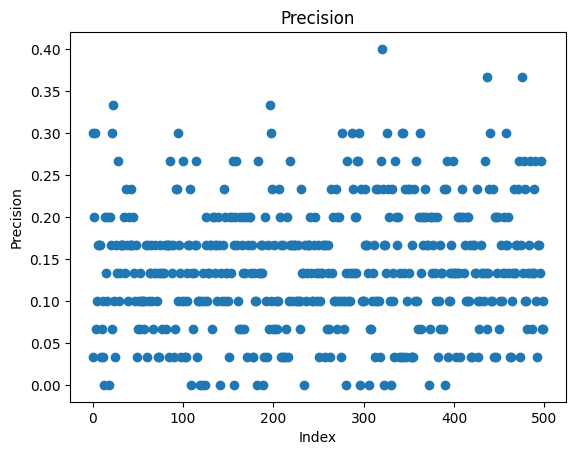

In [26]:
indices = list(range(len(precision)))
plt.scatter(indices, precision)
plt.title("Precision")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.show()

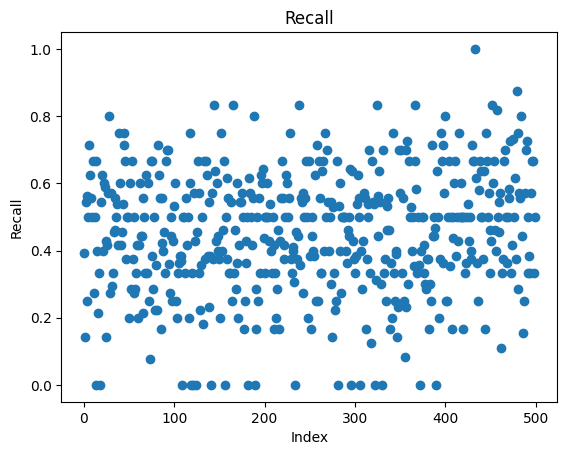

In [24]:
indices = list(range(len(recall)))
plt.scatter(indices, recall)
plt.title("Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.show()

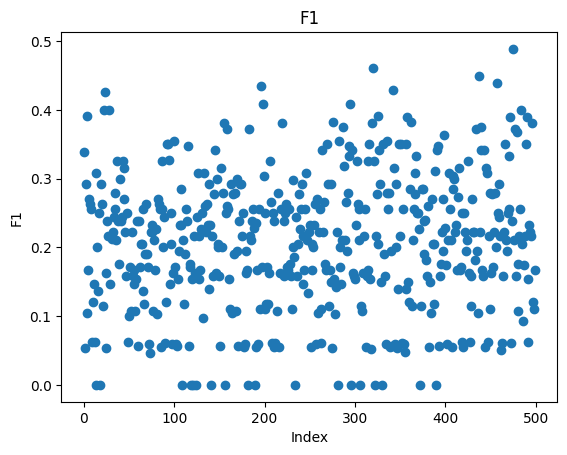

In [25]:
indices = list(range(len(f1)))
plt.scatter(indices, f1)
plt.title("F1")
plt.xlabel("Index")
plt.ylabel("F1")
plt.show()

In [75]:
new_image_path = image_dir + 'miso-butter-roast-chicken-acorn-squash-panzanella.jpg'
new_image_encodings = process_single_image(new_image_path).unsqueeze(0)

In [78]:
model.eval()
with torch.no_grad():
    predicted_encodings = model(new_image_encodings).numpy()

encodings_list = predicted_encodings.flatten().tolist()
encodings_sorted = sorted(range(len(encodings_list)), key=lambda k: encodings_list[k], reverse=True)

top = 20
for i in range(top):
    print(pca_ingredients[encodings_sorted[i]], encodings_list[encodings_sorted[i]])

kosher salt 0.47764235734939575
oil 0.37670570611953735
salt 0.1958949714899063
sugar 0.16583296656608582
cream 0.1205732673406601
ground pepper 0.11468949168920517
onion 0.08517152816057205
butter 0.0680394098162651
paprika 0.067076176404953
parsley 0.05539203807711601
zest 0.051660943776369095
ground cinnamon 0.05096679925918579
vanilla extract 0.04980098828673363
sliced 0.04525395855307579
wine 0.04518023878335953
dijon mustard 0.04175616055727005
flaky sea salt 0.03922448679804802
parmesan 0.03547582030296326
extravirgin oil 0.03464630991220474
ground turmeric 0.03237537294626236


In [ ]:
df[]

# K-MEANS (probably don't need this)

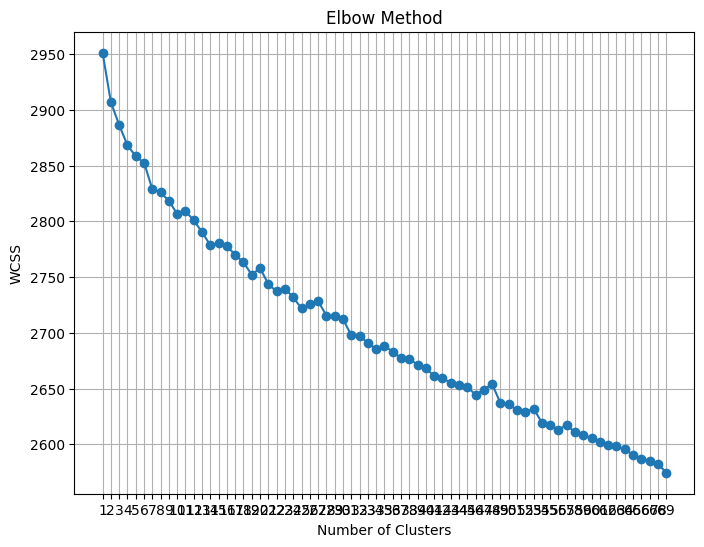

In [36]:
#
# calculate WCSS for different values of k
# DON'T RUN
#
wcss = []
low_range = 1
high_range = 70
for i in range(low_range, high_range):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10, random_state=0)
    kmeans.fit(reduced_ingredients)
    wcss.append(kmeans.inertia_)

# plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(low_range, high_range), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(low_range, high_range, 1))
plt.grid(True)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=61, max_iter=300) 
kmeans.fit(reduced_ingredients) 

KMeans(n_clusters=61)